<a href="https://colab.research.google.com/github/anjimenezp/AI-Genomics/blob/main/AI-Genomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd

pd.set_option('display.width', 200)

def extract_data():
  df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data', header=None, names=['Class', 'Name', 'Sequence'])
  return df

print(extract_data().head(10))

  Class                     Name                                           Sequence
0    EI         ATRINS-DONOR-521                 CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...
1    EI         ATRINS-DONOR-905                 AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...
2    EI         BABAPOE-DONOR-30                 GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...
3    EI        BABAPOE-DONOR-867                GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...
4    EI       BABAPOE-DONOR-2817               GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...
5    EI       CHPIGECA-DONOR-378               CAGACTGGGTGGACAACAAAACCTTCAGCGGTA...
6    EI       CHPIGECA-DONOR-903               CCTTTGAGGACAGCACCAAGAAGTGTGCAGGTA...
7    EI      CHPIGECA-DONOR-1313              CCCTCGTGCGGTCCACGACCAAGACCAGCGGTGA...
8    EI      GCRHBBA1-DONOR-1260              TGGCGACTACGGCGCGGAGGCCCTGGAGAGGTGA...
9    EI      GCRHBBA1-DONOR-1590              AAGCTGACAGTGGACCCGGTCAACTTCAAGGTGA...


In [ ]:
import random
import pandas as pd

def generate_simulated_dna_sequence(length, type):
    """Generate a simulated DNA sequence with more complexity."""
    motifs = {
    'EI': ['GT', 'GTAAGT'],  # Exon-Intron splice sites
    'IE': ['AG', 'CAGG'],  # Intron-Exon splice sites
    'N': ['TATA', 'CAAT', 'AAA', 'TTT', 'CCC', 'GGG']  # Regulatory elements and repetitive sequences
  }

    # def mutate(sequence):
    #     # Ajustar el número de mutaciones en función de la longitud de la secuencia
    #     max_mutations = len(sequence) // 4  # Hasta un 25% de la secuencia
    #     num_mutations = random.randint(1, max(max_mutations, 1))  # Al menos una mutación
    #     mutation_sites = random.sample(range(len(sequence)), k=num_mutations)
    #     for i in mutation_sites:
    #         sequence = sequence[:i] + random.choice('ACGT') + sequence[i+1:]
    #     return sequence

    # sequence = ''
    # while len(sequence) < length:
    #     if type in motifs:
    #         motif = random.choice(motifs[type]) + ''.join(random.choice('ACGT') for _ in range(3))
    #         sequence += mutate(motif)
    #     else:
    #         sequence += mutate(''.join(random.choice('ACGT') for _ in range(6)))
    #     sequence = sequence[:length]
    # return sequence




# def create_simulated_data(num_samples, seq_length):
#     types = ['EI', 'IE', 'N']
#     data = {'seq': [], 'type': []}
#     for _ in range(num_samples):
#         seq_type = random.choice(types)
#         seq = generate_simulated_dna_sequence(seq_length, seq_type)
#         data['seq'].append(seq)
#         data['type'].append(seq_type)
#     return pd.DataFrame(data)

real_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/splice-junction-gene-sequences/splice.data', header=None, names=['type', 'Name', 'seq'])
real_data.drop('Name', axis=1, inplace=True)
real_data = real_data[['seq', 'type']]

# num_samples = 65536
seq_length = 60
# simulated_data = create_simulated_data(num_samples, seq_length)]
real_data = pd.DataFrame(real_data)
print(real_data.head())


                                                 seq type
0                 CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...   EI
1                 AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...   EI
2                 GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...   EI
3                GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...   EI
4               GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...   EI


**Cuantificando las etiquetas**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Añadir una nueva columna al DataFrame con las etiquetas codificadas
real_data['type_encoded'] = label_encoder.fit_transform(real_data['type'])

# Verificar las primeras filas del DataFrame para confirmar la adición
print(real_data.head())


                                                 seq type  type_encoded
0                 CCAGCTGCATCACAGGAGGCCAGCGAGCAGG...   EI             0
1                 AGACCCGCCGGGAGGCGGAGGACCTGCAGGG...   EI             0
2                 GAGGTGAAGGACGTCCTTCCCCAGGAGCCGG...   EI             0
3                GGGCTGCGTTGCTGGTCACATTCCTGGCAGGT...   EI             0
4               GCTCAGCCCCCAGGTCACCCAGGAACTGACGTG...   EI             0


**One_hot_encode**

In [ ]:
import torch
from torch.utils.data import Dataset

def clean_sequence(seq):
    return seq.replace(' ', '').upper()  # Elimina espacios y convierte a mayúsculas

def one_hot_encode(seq):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1], 'N': [0, 0, 0, 0]}
    return torch.tensor([mapping.get(nucleotide, [0, 0, 0, 0]) for nucleotide in seq], dtype=torch.float32)

class SeqDatasetOHE(Dataset):
    def __init__(self, dataframe, seq_col, label_col):
        self.dataframe = dataframe
        self.seq_col = seq_col
        self.label_col = label_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        seq = self.dataframe.iloc[idx][self.seq_col]
        seq = clean_sequence(seq)  # Limpia la secuencia
        label = self.dataframe.iloc[idx][self.label_col]
        return one_hot_encode(seq), label


print(one_hot_encode("CACGAT"))


tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])


**SPLITS DE ENTRENAMIENTO**

In [ ]:
import random

def quick_split(df, split_frac=0.7):
    """Divide el DataFrame en dos conjuntos de manera aleatoria.

    Args:
    df (DataFrame): DataFrame a dividir.
    split_frac (float): Fracción del conjunto para entrenamiento.

    Returns:
    DataFrame: Conjunto de entrenamiento.
    DataFrame: Conjunto restante.
    """
    shuffled = df.sample(frac=1).reset_index(drop=True)
    split_idx = int(len(df) * split_frac)
    train_df = shuffled[:split_idx]
    rest_df = shuffled[split_idx:]
    return train_df, rest_df

# Genera los conjuntos de entrenamiento, validación y prueba
train_df, remaining_df = quick_split(real_data, split_frac=0.7)
val_df, test_df = quick_split(remaining_df, split_frac=0.5)

# Verifica los tamaños de los conjuntos
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras")
print(f"Prueba: {len(test_df)} muestras")


Entrenamiento: 2233 muestras
Validación: 478 muestras
Prueba: 479 muestras


**Preparar DataLoader**

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32  # Puedes ajustar esto según las necesidades de tu modelo y hardware

train_dataset = SeqDatasetOHE(train_df, 'seq', 'type_encoded')
val_dataset = SeqDatasetOHE(val_df, 'seq', 'type_encoded')
test_dataset = SeqDatasetOHE(test_df, 'seq', 'type_encoded')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


**Modelo CNN**

In [ ]:
import torch
import torch.nn as nn

class DNA_CNN(nn.Module):
    def __init__(self, seq_len, num_classes):
        super(DNA_CNN, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * (seq_len // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



# Ejemplo de instanciación del modelo CNN
num_classes = len(real_data['type'].unique())  # Número de tipos únicos de secuencias
model = DNA_CNN(seq_length, num_classes)


**Training loop functions**

**Entrenamiento y Validación**

In [ ]:
import torch.optim as optim
# Definir el número de épocas
num_epochs = 20  # Puedes ajustar este número según tus necesidades

# Cambiar a un optimizador más eficiente como Adam
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Definir la función de perdida
loss_func = nn.CrossEntropyLoss()

# Considera implementar una estrategia de ajuste de ratio de aprendizaje
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

def train_one_epoch(model, train_loader, loss_func, optimizer, device):
    model.train()  # Establecer el modelo en modo de entrenamiento
    total_loss = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Paso hacia adelante
        outputs = model(inputs)
        loss = loss_func(outputs, labels)

        # Paso hacia atrás y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, loss_func, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Ejemplo de cómo ejecutar el bucle de entrenamiento y validación
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, loss_func, optimizer, device)
    val_loss = validate(model, val_loader, loss_func, device)
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/20, Train Loss: 0.9004, Val Loss: 0.5294
Epoch 2/20, Train Loss: 0.4120, Val Loss: 0.2169
Epoch 3/20, Train Loss: 0.2390, Val Loss: 0.1410
Epoch 4/20, Train Loss: 0.1901, Val Loss: 0.1403
Epoch 5/20, Train Loss: 0.1582, Val Loss: 0.1124
Epoch 6/20, Train Loss: 0.1347, Val Loss: 0.1148
Epoch 7/20, Train Loss: 0.1198, Val Loss: 0.1013
Epoch 8/20, Train Loss: 0.0993, Val Loss: 0.1075
Epoch 9/20, Train Loss: 0.1114, Val Loss: 0.1034
Epoch 10/20, Train Loss: 0.1043, Val Loss: 0.1030
Epoch 11/20, Train Loss: 0.0835, Val Loss: 0.1042
Epoch 12/20, Train Loss: 0.0782, Val Loss: 0.1101
Epoch 13/20, Train Loss: 0.0856, Val Loss: 0.1056
Epoch 14/20, Train Loss: 0.0842, Val Loss: 0.0887
Epoch 15/20, Train Loss: 0.0726, Val Loss: 0.1214
Epoch 16/20, Train Loss: 0.0576, Val Loss: 0.1094
Epoch 17/20, Train Loss: 0.0513, Val Loss: 0.0986
Epoch 18/20, Train Loss: 0.0590, Val Loss: 0.1215
Epoch 19/20, Train Loss: 0.0593, Val Loss: 0.0916
Epoch 20/20, Train Loss: 0.0537, Val Loss: 0.1083


**Evaluación del modelo**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, test_loader, device):
    model.eval()  # Establecer el modelo en modo de evaluación
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluar el modelo en el conjunto de prueba
all_preds, all_labels = evaluate_model(model, test_loader, device)

# Calcular y mostrar métricas de rendimiento
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.98      0.94      0.96       122
           1       0.89      0.99      0.94       117
           2       1.00      0.97      0.98       240

    accuracy                           0.97       479
   macro avg       0.96      0.97      0.96       479
weighted avg       0.97      0.97      0.97       479

[[115   7   0]
 [  1 116   0]
 [  1   7 232]]


**Gráficas**

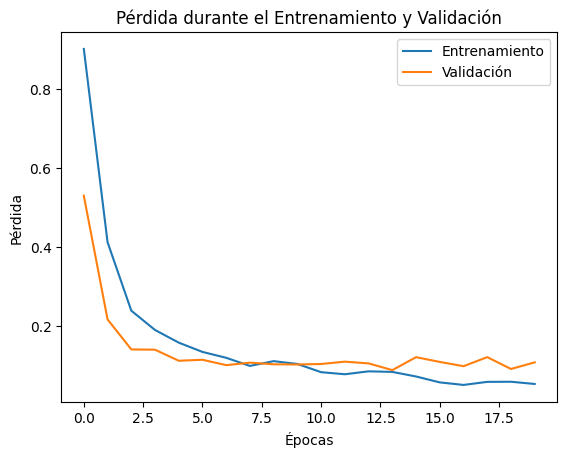

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.title('Pérdida durante el Entrenamiento y Validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

plot_losses(train_losses, val_losses)


In [ ]:
import torch

# Carga tu modelo (asegúrate de que esté en modo de evaluación)
model.eval()

# Cadena de ADN de ejemplo para clasificar
dna_sequence = "GCCCTGGCGCCCAGCACCATGAAGATCAAGGTGAGTCGAGGGGTTGGTGGCCCTCTGCCT"  # Reemplaza esto con tu secuencia

# Codificar la secuencia
encoded_sequence = one_hot_encode(dna_sequence).unsqueeze(0)  # Agrega una dimensión de lote

# Realizar la predicción
with torch.no_grad():
    output = model(encoded_sequence)
    predicted_class = torch.argmax(output, dim=1)

# Imprimir la clase predicha
print(f"Clase predicha: {predicted_class.item()}")


Clase predicha: 0
